# INFS3208 - A4 (Type II)
This project uses the [Global Football Results](https://www.kaggle.com/datasets/muhammadehsan02/global-football-results-18722024/data) dataset.

**NOTE: View in light mode to see figure labels.**

In [1]:
!pip install unidecode

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, to_timestamp, udf, col
from pyspark.sql.types import StringType
from unidecode import unidecode
import matplotlib as plt
import matplotlib.pyplot as plt
import pandas as pd

## Loading Data

In [3]:
spark = SparkSession.builder \
    .appName("HDFS") \
    .getOrCreate()

sc = spark.sparkContext

In [4]:
# Load data
def read_csv(path):
    return spark.read \
    .option("header", "true") \
    .option("quote", "\"") \
    .option("escape", "\\") \
    .csv(f"hdfs://namenode:9000/{path}")

goal_scorers_df = read_csv("Goal_Scorers.csv")
match_results_df = read_csv("Match_Results.csv")
penalty_shootouts_df = read_csv("Penalty_Shootouts.csv")

## Data Tables

In [5]:
goal_scorers_df.show(3)
print("Rows: ", goal_scorers_df.count())
match_results_df.show(3)
print("Rows: ", match_results_df.count())
penalty_shootouts_df.show(3)
print("Rows: ", penalty_shootouts_df.count())

+----------+---------+---------+-------+----------------+------+--------+-------+
|      date|home_team|away_team|   team|          scorer|minute|own_goal|penalty|
+----------+---------+---------+-------+----------------+------+--------+-------+
|1916-07-02|    Chile|  Uruguay|Uruguay| José Piendibene|    44|   FALSE|  FALSE|
|1916-07-02|    Chile|  Uruguay|Uruguay|Isabelino Gradín|    55|   FALSE|  FALSE|
|1916-07-02|    Chile|  Uruguay|Uruguay|Isabelino Gradín|    70|   FALSE|  FALSE|
+----------+---------+---------+-------+----------------+------+--------+-------+
only showing top 3 rows

Rows:  44362
+----------+---------+---------+----------+----------+----------+-------+--------+-------+
|      date|home_team|away_team|home_score|away_score|tournament|   city| country|neutral|
+----------+---------+---------+----------+----------+----------+-------+--------+-------+
|1872-11-30| Scotland|  England|         0|         0|  Friendly|Glasgow|Scotland|  FALSE|
|1873-03-08|  England| S

## Preprocessing

In [6]:
# Drop rows with None values
goal_scorers_df = goal_scorers_df.dropna()
match_results_df = match_results_df.dropna()
# Can keep rows with first_shooter null as not important
penalty_shootouts_df = penalty_shootouts_df.dropna(subset=["date","home_team","away_team","winner"])

# Remove duplicates
# Don't need to filter goal_scorers_df as duplicate goal scorer rows are valid 
match_results_df = match_results_df.dropDuplicates()
penalty_shootouts_df = penalty_shootouts_df.dropDuplicates()

# Filter out goals scored without scorer name
goal_scorers_df = goal_scorers_df.filter(goal_scorers_df.scorer != "NA")
goal_scorers_df = goal_scorers_df.filter(goal_scorers_df.minute != "NA")

# Replace accents with unaccented letters
def remove_accents(s):
    if s is not None:
        return unidecode(s)
    return s

remove_accents_udf = udf(remove_accents, StringType())
goal_scorers_df = goal_scorers_df.withColumn("scorer", remove_accents_udf(goal_scorers_df.scorer))

# Filter out own goals
goal_scorers_df = goal_scorers_df.filter(goal_scorers_df.own_goal == 'FALSE')
goal_scorers_df = goal_scorers_df.drop("own_goal")

# Drop city column from match_results
match_results_df = match_results_df.drop("city")

# Drop new duplicates that may have emerged from processing
match_results_df = match_results_df.dropDuplicates()
penalty_shootouts_df = penalty_shootouts_df.dropDuplicates()

# Convert minutes to int
goal_scorers_df = goal_scorers_df.withColumn("minute", col("minute").cast("int"))

# Convert date strings into date objects
goal_scorers_df = goal_scorers_df.withColumn("date", to_date("date", "yyyy-MM-dd"))
match_results_df = match_results_df.withColumn("date", to_date("date", "yyyy-MM-dd"))
penalty_shootouts_df = penalty_shootouts_df.withColumn("date", to_date("date", "yyyy-MM-dd"))

## CRUD
Deleted and updated values during preprocessing stage. Now saving to source file.

In [7]:
def save(df, name):
    df.coalesce(1).write.format("csv").option("header", "true").save(f"hdfs://namenode:9000/{name}")
    
save(goal_scorers_df, "Goal_Scorers_Processed.csv")
save(match_results_df, "Match_Results_Processed.csv")
save(penalty_shootouts_df, "Penalty_Shootouts_Processed.csv")

## Visualising Initial Data

In [8]:
goal_scorers_pd = goal_scorers_df.toPandas()
match_results_pd = match_results_df.toPandas()
penalty_shootouts_pd = penalty_shootouts_df.toPandas()

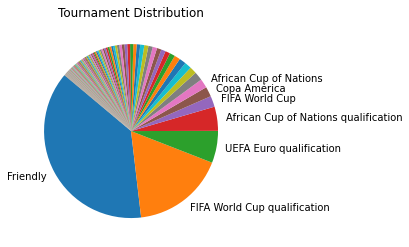

In [9]:
# What are the most played tournaments?
match_results_col = match_results_pd['tournament']
counts = match_results_col.value_counts()
top_names = counts.index[:7]  # Only display top most common games to reduce crowding
labels = [name if name in top_names else '' for name in counts.index]
plt.pie(counts,labels=labels, startangle=140)
plt.title('Tournament Distribution')
plt.show()

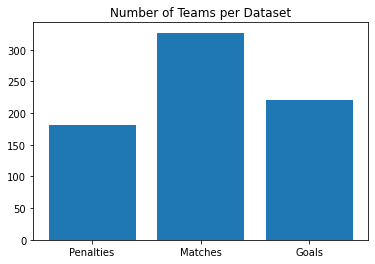

In [10]:
#  How many teams are there in each dataset?
penalties = penalty_shootouts_pd['home_team'].nunique()
matches = match_results_pd['home_team'].nunique()
goals = goal_scorers_pd['home_team'].nunique()

plt.bar(['Penalties', 'Matches', 'Goals'], [penalties, matches, goals])
plt.title("Number of Teams per Dataset")
plt.show()

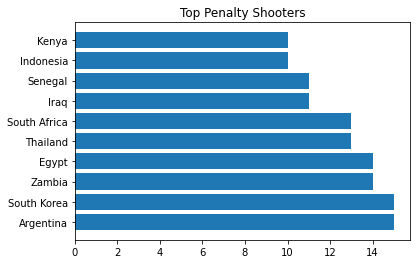

In [11]:
# Which country is the best at penalties?
counts = penalty_shootouts_pd['winner'].value_counts()
counts = counts[:10]
plt.barh(counts.index,counts)
plt.title('Top Penalty Shooters')
plt.show()

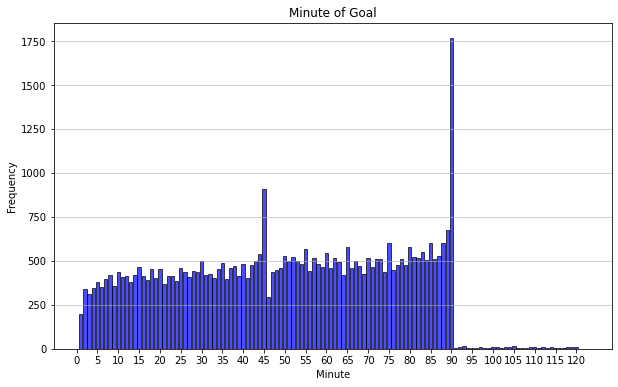

In [12]:
# At what times are goals mostly scored?
distribution = goal_scorers_pd['minute']

# Count the frequency of each unique minute
frequency = distribution.value_counts().sort_index()

# Create the bar chart
plt.figure(figsize=(10, 6)) 
plt.bar(frequency.index, frequency.values, alpha=0.7, color='blue', edgecolor='black')  # Use bar chart for clarity
plt.title('Minute of Goal')
plt.xlabel('Minute')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75) 

# Set x-ticks to show every 5 minutes (or as desired)
plt.xticks(range(0, max(distribution), 5)) 
plt.show()

In [13]:
# Create table views into df
goal_scorers_df.createOrReplaceTempView("Goal_Scorers")
match_results_df.createOrReplaceTempView("Match_Results")
penalty_shootouts_df.createOrReplaceTempView("Penalty_Shootouts")

## Query 1: Top 10 Best FIFA Footballers
Determining the best player by looking at who scores the most, wins the most, and loses the least in the FIFA world cup. The final metric to determine the best player is: 2 * goals + 1.5 * wins - losses.

In [14]:
result_df = spark.sql("""
    WITH scorer_goals AS (
        SELECT 
            gs.scorer, 
            COUNT(*) AS goals, 
            gs.team 
        FROM 
            Goal_Scorers gs
        JOIN 
            Match_Results mr ON gs.date = mr.date 
            AND gs.home_team = mr.home_team 
            AND gs.away_team = mr.away_team
        WHERE 
            mr.tournament = 'FIFA World Cup'
        GROUP BY 
            gs.scorer, gs.team
    ),
    
    scorer_wins AS (
        SELECT 
            gs.scorer, 
            COUNT(*) AS wins, 
            gs.team 
        FROM 
            Goal_Scorers gs
        JOIN 
            Match_Results mr ON gs.date = mr.date 
            AND gs.home_team = mr.home_team 
            AND gs.away_team = mr.away_team
        WHERE 
            mr.tournament = 'FIFA World Cup' 
            AND ((mr.home_team = gs.team AND mr.home_score > mr.away_score) 
                  OR (mr.away_team = gs.team AND mr.away_score > mr.home_score))
        GROUP BY 
            gs.scorer, gs.team
    ), 
    
    scorer_losses AS (
        SELECT 
            gs.scorer, 
            COUNT(*) AS losses, 
            gs.team 
        FROM 
            Goal_Scorers gs
        JOIN 
            Match_Results mr ON gs.date = mr.date 
            AND gs.home_team = mr.home_team 
            AND gs.away_team = mr.away_team
        WHERE 
            mr.tournament = 'FIFA World Cup' 
            AND ((mr.home_team = gs.team AND mr.home_score <= mr.away_score) 
                  OR (mr.away_team = gs.team AND mr.away_score <= mr.home_score))
        GROUP BY 
            gs.scorer, gs.team
    )
    
    SELECT 
        ROW_NUMBER() OVER (ORDER BY (2 * goals + 1.5 * wins - losses) DESC) AS Rank,
        sg.scorer AS Player, 
        sg.team AS Team, 
        Goals, 
        Wins, 
        Losses, 
        (2 * goals + 1.5 * wins - 0.75 * losses) AS Score
    FROM 
        scorer_goals AS sg
    JOIN 
        scorer_wins AS sw ON sg.scorer = sw.scorer AND sg.team = sw.team
    JOIN 
        scorer_losses AS sl ON sg.scorer = sl.scorer AND sg.team = sl.team
    ORDER BY 
        Score DESC
    LIMIT 10;
""")


+----+-----------------+---------+-----+----+------+-----+
|Rank|           Player|     Team|Goals|Wins|Losses|Score|
+----+-----------------+---------+-----+----+------+-----+
|   1|          Ronaldo|   Brazil|   15|  14|     1|50.25|
|   2|   Miroslav Klose|  Germany|   16|  13|     3|49.25|
|   3|      Gerd Muller|  Germany|   14|  12|     2|44.50|
|   4|    Just Fontaine|   France|   13|  10|     3|38.75|
|   6|     Lionel Messi|Argentina|   13|   9|     4|36.50|
|   5| Jurgen Klinsmann|  Germany|   11|  10|     1|36.25|
|   7|    Kylian Mbappe|   France|   12|   9|     3|35.25|
|   8|    Grzegorz Lato|   Poland|   10|   9|     1|32.75|
|   9| Teofilo Cubillas|     Peru|   10|   8|     2|30.50|
|  10|Gabriel Batistuta|Argentina|   10|   8|     2|30.50|
+----+-----------------+---------+-----+----+------+-----+



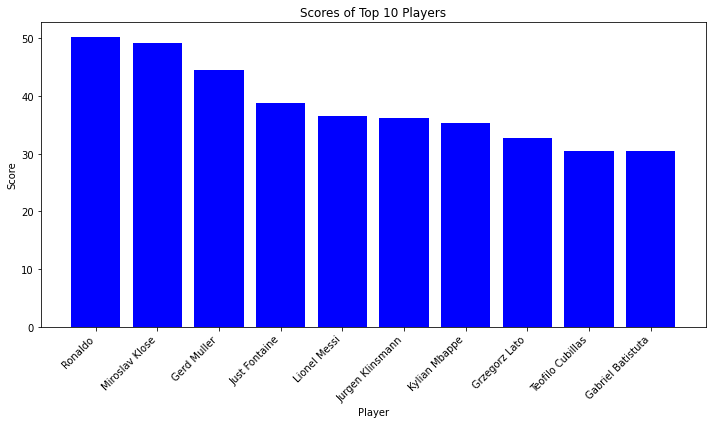

In [15]:
result_df.show()

pandas_df = result_df.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['Player'], pandas_df['Score'], color='blue')
plt.xlabel('Player')
plt.ylabel('Score')
plt.title('Scores of Top 10 Players')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This query determined the best footballer to be Ronaldo from Brazil. In FIFA world cups, he scored 15 goals, won 14 matches and lost only once. The top two players, Ronaldo and Klose, are close in score with the others trailing behind.


The `Score` formula heavily weighted goal scoring and wins but not losses. This was an arbitrary choice made to reflect what I think makes the best player. As a result, a player like Messi will score higher than Klinsmann despite having many more losses as losses have a low weight.

### Query 2: Home Ground Advantage in Penalty Shootouts w.r.t. Friendly vs Tournament
Determining if a home ground advantage is stronger/weaker in friendly or tournament matches for penalty shootouts.

In [16]:
result_df = spark.sql("""
    WITH comp_home_penalties AS (
        SELECT 
            ps.home_team, 
            ps.away_team, 
            ps.winner
        FROM 
            Match_Results mr
        RIGHT JOIN 
            Penalty_Shootouts ps 
        ON 
            ps.date = mr.date 
            AND ps.home_team = mr.home_team 
            AND ps.away_team = mr.away_team
            AND mr.neutral <> 'TRUE'
        WHERE 
            neutral <> 'null'
            AND tournament <> 'Friendly'
    ),
    
    comp_penalties_count AS (
        SELECT 
            SUM(CASE WHEN winner = home_team THEN 1 ELSE 0 END) AS Home_Team_Wins,
            SUM(CASE WHEN winner = away_team THEN 1 ELSE 0 END) AS Away_Team_Wins
        FROM 
            comp_home_penalties
    ),

    friendly_home_penalties AS (
        SELECT 
            ps.home_team, 
            ps.away_team, 
            ps.winner
        FROM 
            Match_Results mr
        RIGHT JOIN 
            Penalty_Shootouts ps 
        ON 
            ps.date = mr.date 
            AND ps.home_team = mr.home_team 
            AND ps.away_team = mr.away_team
            AND mr.neutral <> 'TRUE'
        WHERE 
            neutral <> 'null'
            AND tournament = 'Friendly'
    ),
    
    friendly_penalties_count AS (
        SELECT 
            SUM(CASE WHEN winner = home_team THEN 1 ELSE 0 END) AS Home_Team_Wins,
            SUM(CASE WHEN winner = away_team THEN 1 ELSE 0 END) AS Away_Team_Wins
        FROM 
            friendly_home_penalties
    )
    
    SELECT *
    FROM comp_penalties_count
    
    UNION ALL 
    
    SELECT *
    FROM friendly_penalties_count;
""")


+--------------+--------------+
|Home_Team_Wins|Away_Team_Wins|
+--------------+--------------+
|           122|           101|
|            25|            18|
+--------------+--------------+



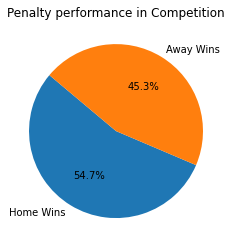

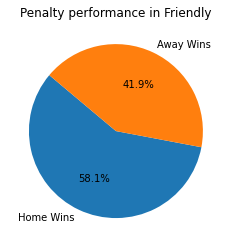

In [17]:
result_df.show()

comp = result_df.take(1)[0]
plt.pie(comp,labels=["Home Wins", "Away Wins"], startangle=140, autopct='%1.1f%%')
plt.title('Penalty performance in Competition')
plt.show()

friendly = result_df.take(2)[1]
plt.pie(friendly,labels=["Home Wins", "Away Wins"], startangle=140, autopct='%1.1f%%')
plt.title('Penalty performance in Friendly')
plt.show()

This query determined that a home ground advantage is not more prominent in competitive games than friendly ones for penalty shootouts. In competition, the home team wins 54.7% of the time compared to 58.1% of the time in friendly games. However, due to there not being much data for friendly penalty shootouts, the difference was deemed insignificant. 

In both friendly and competitive matches the home team wins penalty shootouts more often.

### Query 3: Does the first team to score win?
Determining how well you can use the first goal scored to predict the overall match outcome.

In [18]:
result_df = spark.sql("""
    WITH goal_orders AS (
        SELECT *,
               ROW_NUMBER() OVER (PARTITION BY date, home_team, away_team ORDER BY minute) AS rn
        FROM Goal_Scorers
    ),
    
    first_goals AS (
        SELECT 
            go.team AS first_goal, 
            CASE
                WHEN mr.home_score > mr.away_score THEN mr.home_team 
                WHEN mr.home_score < mr.away_score THEN mr.away_team
                ELSE 'Tie'
            END AS winner
        FROM 
            Match_Results mr
        JOIN 
            goal_orders go
        ON 
            go.date = mr.date
            AND go.away_team = mr.away_team
            AND go.home_team = mr.home_team
    )
    
    SELECT
        SUM(CASE WHEN first_goal = winner THEN 1 ELSE 0 END) AS first_goal_wins,
        SUM(CASE WHEN first_goal <> winner THEN 1 ELSE 0 END) AS first_goal_loses,
        SUM(CASE WHEN winner = 'Tie' THEN 1 ELSE 0 END) AS ties
    FROM 
        first_goals
""")


+---------------+----------------+----+
|first_goal_wins|first_goal_loses|ties|
+---------------+----------------+----+
|          32168|           11113|5642|
+---------------+----------------+----+



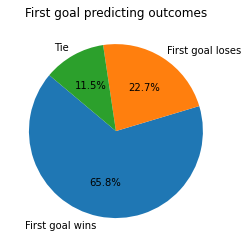

In [19]:
result_df.show()

first_wins = result_df.take(1)[0]
plt.pie(first_wins,labels=["First goal wins", "First goal loses", "Tie"], startangle=140, autopct='%1.1f%%')
plt.title('First goal predicting outcomes')
plt.show()

This query determined that the first team to score wins 65.8% of the time, loses 22.7% of the time, and ties 11.5% of the time. Therefore, the first team to score tends to be more likely to win.

### Query 4: The Most Exciting Tournament
Determined the most exciting tournament per scoring average, proportion of goals scored in the last quarter, and how often they go to penalty shootout. Score = 3 * avg total goals + 10.5 * proportion of goals in last quarter + 20 * normalised penalty occurence propability.

In [20]:
results_df = spark.sql("""
    WITH avg_scoring AS (
        SELECT 
            AVG(home_score + away_score) AS average_goals, 
            tournament, 
            AVG(home_score - away_score) AS closeness
        FROM 
            Match_Results mr
        GROUP BY 
            tournament
    ),
    
    last_quarter_goals AS (
        SELECT 
            tournament, 
            SUM(CASE WHEN minute >= 67.5 THEN 1 ELSE 0 END) / COUNT(*) AS last_quarter
        FROM 
            Match_Results mr
        JOIN 
            Goal_Scorers gs ON 
                gs.date = mr.date 
                AND gs.home_team = mr.home_team 
                AND gs.away_team = mr.away_team
        GROUP BY 
            tournament
    ),
    
    penalty_counts AS (
        SELECT 
            tournament, 
            COUNT(*) AS totals
        FROM 
            Match_Results mr
        JOIN 
            Penalty_Shootouts ps ON 
                ps.date = mr.date 
                AND ps.home_team = mr.home_team 
                AND ps.away_team = mr.away_team
        GROUP BY 
            tournament
    ),
     
    match_counts AS (
        SELECT 
            tournament, 
            COUNT(*) AS total_matches
        FROM 
            Match_Results
        GROUP BY 
            tournament
    ),
        
    normalised_penalty_counts AS (
        SELECT 
            pc.tournament, 
            (pc.totals / mc.total_matches) AS normalised_penalty_count
        FROM 
            penalty_counts pc
        JOIN 
            match_counts mc ON 
                pc.tournament = mc.tournament
    )
    
    SELECT 
        ROW_NUMBER() OVER (ORDER BY (3 * average_goals + 10.5 * COALESCE(last_quarter, 0) + 20 * COALESCE(normalised_penalty_count, 0)) DESC) AS Rank,
        as.Tournament,
        ROUND(average_goals, 2) AS Average_Goal_Count,
        ROUND(COALESCE(last_quarter, 0), 2) AS Last_Quarter_Goals,
        ROUND(COALESCE(normalised_penalty_count, 0), 4) AS Penalty_Shootout_Rate,
        ROUND(3 * average_goals + 10.5 * COALESCE(last_quarter, 0) + 20 * COALESCE(normalised_penalty_count, 0), 2) AS Score
    FROM 
        avg_scoring AS as
    JOIN 
        last_quarter_goals lqg ON as.tournament = lqg.tournament
    LEFT JOIN 
        normalised_penalty_counts npc ON npc.tournament = as.tournament
    ORDER BY 
        score DESC
""")


+----+--------------------+------------------+------------------+---------------------+-----+
|Rank|          Tournament|Average_Goal_Count|Last_Quarter_Goals|Penalty_Shootout_Rate|Score|
+----+--------------------+------------------+------------------+---------------------+-----+
|   1|       Olympic Games|              4.87|              0.25|                  0.0| 17.2|
|   2| Oceania Nations Cup|              4.11|              0.31|               0.0071|15.73|
|   4|CONMEBOL–UEFA Cup...|              2.33|              0.17|               0.3333|15.42|
|   3|   NAFC Championship|              4.33|              0.23|                  0.0|15.42|
|   5|British Home Cham...|               3.5|              0.41|                  0.0|14.77|
|   6|  Confederations Cup|              3.02|              0.33|               0.0429|13.38|
|   7|        Copa América|              3.14|              0.29|               0.0378|13.23|
|   8|       AFC Asian Cup|              2.66|              

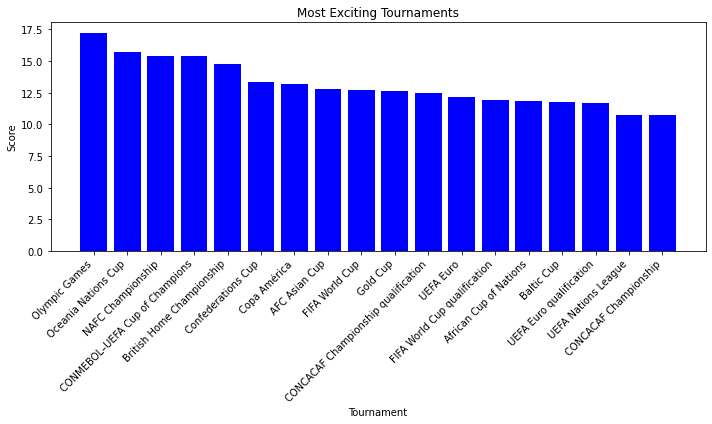

In [21]:
results_df.show()

pandas_df = results_df.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['Tournament'], pandas_df['Score'], color='blue')
plt.xlabel('Tournament')
plt.ylabel('Score')
plt.title('Most Exciting Tournaments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Conclusion

This project determined:
1) Ronaldo of Brazil to be the best footballer.

2) The home team tends to win more in penalty shootouts but the home advantage is not more potent in a compeitive match versus a friendly one for penalty shootouts. 

3) The first team to score is more likely to win.

4) The most exciting tournnament to be the Olympic games.